In [1]:
import os,shutil
import numpy as np
import torch
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import WeightedRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

from imbalanced import ImbalancedDatasetSampler

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
data_folder = 'NewData'
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
import smote_variants as sv
from imp import reload

In [4]:
# Not tested. hard code as below
def MovePicToFolder(meta_csv_file, image_col_name, type_col_name, pic_ext_name = 'jpg'):
    meta_data = pd.read_csv(meta_csv_file)
    
    filename_list = meta_data[image_col_name].values.tolist()
    folder_list = meta_data[type_col_name].values.tolist()
    
    #Create Folder if not exist
    df_group = meta_data.groupby(by = type_col_name)
    Cata_list = list(df_group.groups.keys())
    
    for i in range(len(Cata_list)):
        path = os.path.join(data_folder, Cata_list[i])
    if not os.path.exists(path):
        os.mkdir(path)
        
    # Move pictres to corresponding type folders
    # We can also run multi-thread to do such things, but run only one-time, so .....
    # Just like the Pytorch number_workers
    for i in range(len(filename_list)):
        filename = os.path.join(data_folder, filename_list[i] +'.'+ pic_ext_name)
        foldername = os.path.join(data_folder, folder_list[i])
        shutil.move(filename, foldername)
        
# MovePicToFolder('HAM10000_metadata.csv',)

In [3]:
##########################################################################
####################       Deprecated          ###########################
###        Run only one time, image already classified into spec folders
##########################################################################

meta_data = pd.read_csv('HAM10000_metadata.csv')

filename_list = meta_data['image_id'].values.tolist()
folder_list = meta_data['dx'].values.tolist()

df_group = meta_data.groupby(by = 'dx')
Cata_list = list(df_group.groups.keys())
Cata_list
data_folder = 'NewData'
for i in range(len(filename_list)):
    filename = os.path.join(data_folder, filename_list[i]+'.jpg')
    foldername = os.path.join(data_folder, folder_list[i])
    shutil.move(filename, foldername)
    

Error: Destination path 'NewData/bkl/ISIC_0027419.jpg' already exists

In [8]:
meta_data = pd.read_csv('HAM10000_metadata.csv')
filename_list = meta_data['image_id'].values.tolist()
filetype_list = meta_data['dx'].values.tolist()
dict_type = dict(zip(filename_list, filetype_list))

df_group = meta_data.groupby(by = 'dx')
Cata_list = list(df_group.groups.keys())

cata_len = len(Cata_list)
total_corret = 0

In [8]:
#Validate the folder classfiy correctly
for i in range(len(Cata_list)):
    SubFoldeNname = os.path.join(data_folder,Cata_list[i])
    print("SubFolder name is {}".format(SubFoldeNname))
    total = 0
    
    for sub_file in os.listdir(SubFoldeNname):
        sub_file = os.path.splitext(sub_file)[0]
        #if dict_type[sub_file] == Cata_list[i]:
        #    total_corret += 1
        total += 1
        
        else:
            print('%s is not %s, correct type is %s',sub_file, SubFoldeNname, dict_type[sub_file])

print("Total correct number is:",total_corret)

SubFolder name is NewData/akiec
SubFolder name is NewData/bcc
SubFolder name is NewData/bkl
SubFolder name is NewData/df
SubFolder name is NewData/mel


KeyError: 'ISIC_0010990'

In [9]:
from enum import Enum
class ModelType(Enum):
    RESNET = 1
    VGG = 2
    OTHER = 3
    
modeltype = ModelType.RESNET
modeltype


## Load and Transform our Data
# Orignal Data download from https://github.com/udacity/dermatologist-ai
data_folder = 'NewData'
data_dir = data_folder 

# classes are folders in each directory with these names
classes = Cata_list

valid_size = 0.109
train_size = 0.89
test_size = 0.01

In [25]:
## Load and Transform our Data
# Orignal Data download from https://github.com/udacity/dermatologist-ai

#data_dir = 'd:\\Data\\'
#train_dir = os.path.join(data_dir, 'train')
#test_dir = os.path.join(data_dir, 'test')
#valid_dir = os.path.join(data_dir, 'valid')

# classes are folders in each directory with these names
#classes = ['melanoma', 'nevus', 'seborrheic_keratosis']

##########################################################################
####################       Deprecated          ###########################
##########################################################################
def CheckFileAccuracy(train_dir,filename = 'metadata.csv'):
    #metadata.csv contains the classfy info
    # We only need to verify 
    meta_data = pd.read_csv('metadata.csv')

    lista = meta_data['name'].values.tolist()
    listb = meta_data['meta.clinical.diagnosis'].values.tolist()

    dict_type = dict(zip(lista, listb))

    melanoma_correct = 0
    nevus_correct = 0
    seb_correct = 0
    
    train_dir_mela = os.path.join(train_dir,'melanoma')
    train_dir_nevus = os.path.join(train_dir,'nevus')
    train_dir_seb = os.path.join(train_dir,'seborrheic_keratosis')

    for file in os.listdir(train_dir_mela):
        file = os.path.splitext(file)[0]
        if dict_type[file] == 'melanoma':
            melanoma_correct += 1
        else:
            print('%s is not melanoma, correct type is %s',file, dict_type[file])

    for file in os.listdir(train_dir_nevus):
        file = os.path.splitext(file)[0]
        if dict_type[file] == 'nevus':
            nevus_correct += 1
        else:
            print('%s is not nevus, correct type is %s',file, dict_type[file])

    for file in os.listdir(train_dir_seb):
        file = os.path.splitext(file)[0]
        if dict_type[file] == 'seborrheic keratosis':
            seb_correct += 1
        else:
            print('%s is not seborrheic_keratosis, correct type is %s',file, dict_type[file])
    
    print('melanoma Accuracy %d / %d' %( melanoma_correct ,len(os.listdir(train_dir_mela))))
    print('nevus Accuracy %d / %d' %(nevus_correct ,len(os.listdir(train_dir_nevus))))
    print('seborrheic keratosis Accuracy %d / %d' %( seb_correct ,len(os.listdir(train_dir_seb))))
    
#CheckFileAccuracy(train_dir)
#CheckFileAccuracy(valid_dir)


In [23]:

sample_wight=([1,2,2,0.9,2,7,0.4])
type(sample_wight)

sample_wight[5]


7

In [10]:
#Randowm Resize 
data_transform = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomAffine(20),
        #transforms.RandomPerspective(distortion_scale=0.5,p=0.5,interpolation=3) ,
        transforms.ToTensor(), 
        #transforms.Normalize(
        #    mean=[0.485, 0.456, 0.406],
        #    std=[0.229, 0.224, 0.225])
        ])

train_data = datasets.ImageFolder(data_folder, transform=data_transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

# Train Split 
train_valid_split = int(np.floor((train_size+valid_size) * num_train)) 
valid_split = int(np.floor( train_size* num_train))

train_valid_idx, test_idx = indices[:train_valid_split], indices[train_valid_split:]
train_idx, valid_idx = indices[ :valid_split], indices[valid_split:train_valid_split]

# define samplers for obtaining training and validation batches

#class_wight name : akiec, bcc, bkl, df, mel, nv, vasc
sample_wight = [1,2,2,0.9,2,5,0.4]

sample_wight111 = ([1,2,2,1,2,5,1])

sample_wight111 = ([1,1,1,1,4,7,1])

train_imb = ImbalancedDatasetSampler(dataset=train_data,class_weight=sample_wight111, indices=train_idx)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)



indices is: [6575, 3596, 4104, 3499, 4093, 515, 5516, 124, 3068, 6010, 4369, 4850, 6532, 4475, 6013, 5191, 391, 5740, 185, 3447, 3089, 1417, 7473, 6305, 1993, 1113, 5240, 612, 661, 4989, 7043, 2479, 7061, 7151, 4153, 6455, 560, 4258, 1112, 7406, 171, 4953, 2508, 1934, 2097, 6533, 1311, 7299, 3641, 1907, 4252, 2034, 454, 2289, 1389, 3135, 6114, 2064, 3869, 4890, 1616, 2591, 5036, 6810, 4275, 3393, 4609, 5574, 4413, 738, 6268, 4968, 346, 5484, 215, 298, 6312, 5378, 5864, 745, 2146, 5889, 6058, 3057, 886, 512, 2547, 4846, 1890, 3799, 1436, 359, 46, 5926, 2084, 425, 4907, 2176, 2546, 4976, 5961, 1409, 1466, 4004, 787, 602, 7391, 1054, 6723, 4231, 2639, 2271, 2414, 7408, 1577, 6806, 6307, 30, 4387, 676, 2583, 2459, 3358, 5254, 4261, 4183, 6935, 6342, 5617, 2439, 7434, 5615, 138, 499, 4337, 3318, 3725, 152, 7280, 1404, 5658, 4537, 5792, 2504, 2554, 2559, 7003, 6045, 6664, 5782, 529, 6733, 5315, 7101, 5391, 5786, 4894, 3741, 2162, 6076, 5829, 7227, 1481, 3240, 4103, 2896, 4746, 2067, 6931, 68

In [33]:
train_data.imgs[2000]

('NewData/df/ISIC_0029891.jpg', 3)

In [41]:
print(len(train_idx))
print(len(valid_idx))

print(num_train)
#print(indices) = list(range(num_train))

6804
833
7645


In [15]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [16]:
ssss = np.array([1,1,1,1,1,1,1])
aaaa = 1./sum(ssss)

reslu = ssss * sample_wight
print(reslu)

train_imb_sampler = ImbalancedDatasetSampler(train_data,train_idx,bUseWeight=True, weight=sample_wight)

[1.  2.  1.  1.  2.  0.7 1. ]


In [11]:
batch_size = 64
num_workers= 10
train_data = datasets.ImageFolder(data_dir, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    #sampler=train_imb, num_workers=num_workers )
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

In [12]:
def visual_data(data_loader,row_num,col_num):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(row_num*col_num):
        ax = fig.add_subplot(col_num, row_num, idx+1, xticks=[], yticks=[])
        
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

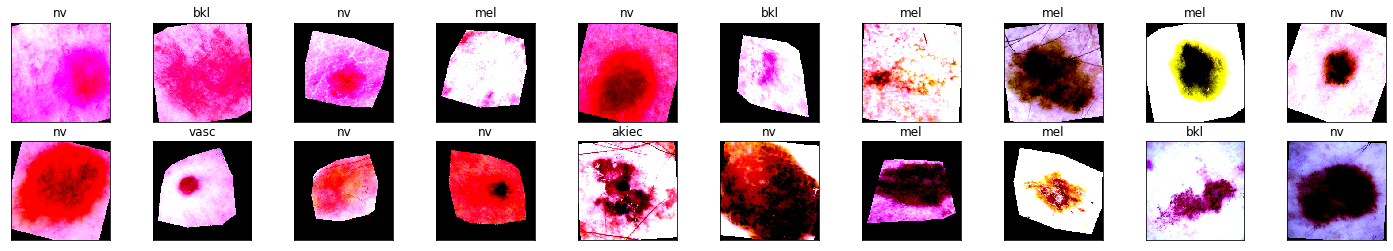

In [15]:
visual_data(train_loader,10,2)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

if modeltype == ModelType.RESNET:
    training_model = models.resnet152(pretrained=True)
if modeltype == ModelType.VGG:
    training_model = models.vgg19(pretrained=True)
    
#Freeze the parameters
for param in training_model.parameters():
    param.requires_grad_(False)
    
print(training_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
full_connected_layers_new = nn.Sequential(nn.Linear(training_model.fc.in_features, 512),
                          #nn.BatchNorm1d(512),
                          nn.ReLU(),
                          nn.Dropout(0.5),
                          nn.Linear(512, 128),
                          #nn.BatchNorm1d(128),
                          nn.ReLU(),
                          nn.Dropout(0.4),            
                          nn.Linear(128, len(classes))) 

training_model.fc= full_connected_layers_new#full_connected_layers

# if GPU is available, move the model to GPU
if train_on_gpu:
    training_model.cuda()

print(training_model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=128, out_features=7, bias=True)
)


In [15]:
import torch.optim as optim
#Learning rate
lr = 0.0001
n_epochs = 20

#class_wight name : akiec, bcc, bkl, df, mel, nv, vasc
class_wight =torch.FloatTensor([1,2,1,1,2,0.7,1])

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (Adam) and learning rate = 0.0001
optimizer = optim.Adam(training_model.fc.parameters(), lr=lr)

In [16]:
train_loss_list = list()
valid_loss_list = list()

#If train and valid_loss less than np.inf  save the valid_loss
#Or shall we do some linear combination train_loss_min and valid_loss_min? such as α*train_loss_min + β*valid_loss_min

train_loss_min = np.inf

model_dir = 'model/'
model_name = 'train_model_2.pt'
save_path = model_dir + model_name
training_model.load_state_dict(torch.load("model/back_train_model_82.pt"))

<All keys matched successfully>

In [31]:
# back_train_model_2
back_model_name = 'back_train_model_2.pt'
load_path = model_dir + back_model_name
training_model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [107]:
aaaa = np.array([[1],[4]])
ssss = torch.from_numpy(aaaa)
print((len(ssss)))

a = 3
b= 4
a!=b

2


True

In [109]:
#noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noise_factor = 0.1
def train_net(train_model,n_epochs, train_loss_list, valid_loss_list,criterion,optimizer,confuse_matrix,model_save_path):
    valid_loss_min = np.inf
    train_loss_min = np.inf
    valid_accuracy = 0
    valid_accuracy_min = 0
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        ######################    
        # Training the model #
        ###################### 
        train_model.train()
        train_loss = 0.0
        
        # train on batches of data, assumes you already have train_loader
        for batch_i, (data, target) in enumerate(train_loader):
            if train_on_gpu: 
                data, target = data.cuda(), target.cuda()
            
            #noisy_imgs = data + noise_factor * torch.randn(*data.shape).cuda()
            
            optimizer.zero_grad()
            
            output = train_model(data)
            #output = train_model(noisy_imgs)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss = (train_loss * batch_i + loss.data) /  (batch_i + 1)
            train_loss_list.append(train_loss)
            print('Batch_i: {} \tTraining Loss: {:.6f} \t'.format(batch_i, train_loss,))
            
        ######################    
        # Valid the model #
        ###################### 
        train_model.eval()
        valid_loss = 0
        
        class_correct = list(0. for i in range(len(classes)))
        class_total = list(0. for i in range(len(classes)))
        confuse_matrix = np.zeros((cata_len,cata_len))
        
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            output = train_model(data)
            loss = criterion(output, target)
            
            _, pred = torch.max(output, 1)
            
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            
            for i in range(len(data)):   
                label = target.data[i]
                pred_label = pred.data[i]
                
                # we have a corner case here. if there is only one single data in the last batch
                # np.squeeze will make shape(1,) to shape(), so the  correct[i] will raise an error"too many indices for array"
                # Since correct is only one data, doesn't have the index [i]
                if len(data) != 1:
                    class_correct[label] += correct[i].item()
                else:
                    class_correct[label] += correct.item()
                class_total[label] += 1

                confuse_matrix[label][pred_label] += 1

            valid_loss = (valid_loss * batch_i + loss.data) /  (batch_i + 1)
            valid_loss_list.append(valid_loss)
            
            
        for i in range(len(classes)):
            if class_total[i] > 0:
                print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                    classes[i], 100 * class_correct[i] / class_total[i],
                    np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
        
        valid_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
        
        print('\n Epoch: %d Test Accuracy (Overall): %2d%% (%2d/%2d)' % (epoch,
            valid_accuracy,
            np.sum(class_correct), np.sum(class_total)))
            
        # print loss statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        print('Confusing matrix is:\n',Cata_list)
        print(confuse_matrix)
        
        ## save the model if validation loss has decreased
        #if train_loss < train_loss_min:
        #    train_loss_min = train_loss
        if valid_accuracy < valid_loss_min:
            valid_loss_min = valid_accuracy
            torch.save(train_model.state_dict(), model_save_path )
            print("save to path ",model_save_path)

    print('Finished Training')


n_epochs = 10
confusion_matrix = np.zeros((cata_len,cata_len))
train_net(training_model,n_epochs,train_loss_list, valid_loss_list,criterion, optimizer,confuse_matrix = confusion_matrix
         ,model_save_path = save_path)

In [110]:

n_epochs = 5

train_net(training_model,n_epochs,train_loss_list, valid_loss_list,criterion, optimizer,
          confuse_matrix = confusion_matrix ,model_save_path = save_path)

correct is: [ True False  True False  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True False  True  True  True  True
  True  True  True  True  True False  True False False False  True  True
 False  True  True False False False  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True False
  True  True False  True]
correct_tensor shape : torch.Size([64])
correct is: [ True  True  True  True  True  True  True  True False  True  True False
  True  True False  True  True  True  True  True  True False  True  True
  True  True False  True  True  True  True  True  True  True False  True
  True False  True  True  True  True  True  True  True False False  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True False  True]
correct_tensor shape : torch.Size([64])
correct is: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  Tru

correct is: [ True False  True  True  True False  True  True  True  True False False
  True  True  True  True  True  True  True  True  True False  True  True
 False False  True  True False False  True  True False  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True False  True False  True False  True  True False False False  True
  True  True False  True]
correct_tensor shape : torch.Size([64])
correct is: [False  True  True  True  True False  True  True  True  True  True  True
  True False  True  True  True  True False  True  True False False False
  True  True False  True  True  True  True  True False False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False  True  True  True  True  True False  True
  True  True  True  True]
correct_tensor shape : torch.Size([64])
correct is: [ True False  True  True False  True  True False False False  True  True
  True False False  True  Tru

correct is: [ True  True  True False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True False False  True False  True  True  True  True  True  True  True
  True  True False  True]
correct_tensor shape : torch.Size([64])
correct is: [ True  True  True  True False  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True False  True False  True  True False  True  True False  True
  True  True  True  True False  True  True False False  True False  True
  True  True  True False False  True  True  True  True  True False  True
  True  True  True  True]
correct_tensor shape : torch.Size([64])
correct is: [ True  True  True  True  True  True  True False  True  True  True  True
 False False  True False  Tru

correct_tensor shape : torch.Size([1])
Test Accuracy of akiec: 52% (20/38)
Test Accuracy of   bcc: 70% (34/48)
Test Accuracy of   bkl: 72% (116/160)
Test Accuracy of    df: 30% ( 4/13)
Test Accuracy of   mel: 75% (172/228)
Test Accuracy of    nv: 86% (284/329)
Test Accuracy of  vasc: 82% (14/17)

 Epoch: 3 Test Accuracy (Overall): 77% (644/833)
Epoch: 3 	Training Loss: 0.000000 	Validation Loss: 0.623194
Confusing matrix is:
 ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[[ 20.   7.   3.   1.   7.   0.   0.]
 [  4.  34.   3.   0.   5.   2.   0.]
 [  5.   4. 116.   0.  24.  11.   0.]
 [  0.   0.   1.   4.   4.   4.   0.]
 [  3.   2.  27.   1. 172.  23.   0.]
 [  0.   1.  18.   0.  26. 284.   0.]
 [  0.   0.   1.   0.   1.   1.  14.]]
correct is: [ True  True False False  True  True  True  True  True  True  True False
  True  True False  True  True  True False  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True Fa

In [28]:
import smote_variants as sv

ModuleNotFoundError: No module named 'minisom'

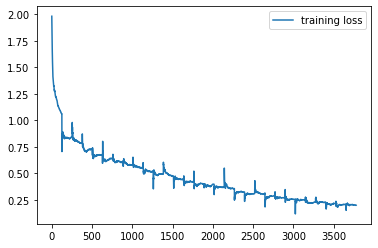

In [53]:
plt.plot(train_loss_list,label = "training loss")
plt.legend()

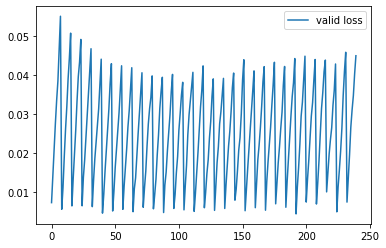

In [54]:
plt.plot(valid_loss_list,label = "valid loss")
plt.legend()

In [13]:
# This is test_code
for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    
    
    break 

In [17]:
aaa = list(1. for i in range(len(classes)))
bbb = list(1. for i in range(len(classes)))

In [23]:
aaa = list(2. for i in range(len(classes)))
aaa

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

In [35]:
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

for batch_idx,(data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    #output = resnet_50(data)
    output = training_model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)   
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(len(data)):   
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
        
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

    

Test Loss: 0.123030

Test Accuracy of akiec: 57% (83/144)
Test Accuracy of   bcc: 60% (127/210)
Test Accuracy of   bkl: 51% (224/432)
Test Accuracy of    df: 34% (22/63)
Test Accuracy of   mel: 56% (302/537)
Test Accuracy of    nv: 91% (2812/3075)
Test Accuracy of  vasc: 66% (32/48)

Test Accuracy (Overall): 79% (3602/4509)


In [58]:
class_total

[49.0, 89.0, 167.0, 17.0, 165.0, 999.0, 17.0]